### Download data
1) https://drive.google.com/file/d/13Qm6ztAmVyBHvo_mch6gk-2VYKUHeRuu/view?usp=sharing  
2) https://docs.google.com/spreadsheets/d/1SIf2vawr2VWwme_6v_VZyHivJ502bWFN70SQLf-iBkM/edit?usp=sharing
    save as bad_ids.csv

In [ ]:
!tar -xf inno_stats.tar.gz -C ./data

### Delete bad ids from csvs

In [29]:
!pip install pandas scipy matplotlib

  Using cached matplotlib-3.4.2-cp38-cp38-win_amd64.whl (7.1 MB)
  Using cached kiwisolver-1.3.1-cp38-cp38-win_amd64.whl (51 kB)
  Using cached Pillow-8.2.0-cp38-cp38-win_amd64.whl (2.2 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [1]:
import pandas as pd

In [2]:
def clear_df(groups_df, bad_ids):
    is_bad = groups_df['id_card'].isin(bad_ids)
    groups_df.drop(groups_df[is_bad].index, inplace=True)

In [3]:
bad_ids_df = pd.read_csv('data/bad_ids.csv', index_col=0)
bad_ids = bad_ids_df['id_card'].tolist()

In [5]:
file_names = ['09_groups.csv', '10_groups.csv', '11_groups.csv']

for file_ in file_names[1:]:
    groups_df = pd.read_csv(f'data/{file_}')
    clear_df(groups_df, bad_ids)
    groups_df.to_csv(f'data/cleared_{file_}')
    del groups_df

### Read processed data

In [2]:
import pandas as pd

In [3]:
dataset_to_read = 'cleared_' + '09_groups.csv'
df = pd.read_csv(f'data/{dataset_to_read}', index_col=0)

C:\ProgramData\Miniconda3\envs\statistics_hw2\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


## Task 1

### Description
Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if a bunch of money is going to spend)

### Solution
Let's state null and alternative hypothesis:  
H0: buying discounted products does not depend on the average order sum  
H1: buying discounted products depends on the average order sum   
We need to reject H0

In [5]:
receipts_data = df.groupby('id_doc')

In [6]:
receipts_average = receipts_data['sum'].mean()

In [7]:
discounts_number = receipts_data['is_green'].sum()

In [17]:
averages_with_discounted_products = receipts_average[discounts_number != 0].tolist()
averages_without_discounted_products = receipts_average[discounts_number == 0].tolist()

In [18]:
len(averages_with_discounted_products), len(averages_without_discounted_products)

(1064042, 5840783)

In [21]:
from scipy.stats import ttest_ind

ttest_ind(averages_with_discounted_products, averages_without_discounted_products)

Ttest_indResult(statistic=-379.12545333959457, pvalue=0.0)

p-value is very small, thus we can reject H0

## Task 2
### Description
Prove that the frequency of shopping grows around the wage taking days (1-6 days of each month, 20 -26 days of each month)

In [42]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

In [43]:
number_of_purchases_per_day = df.groupby(df['date'].dt.day)['id_doc'].count() 

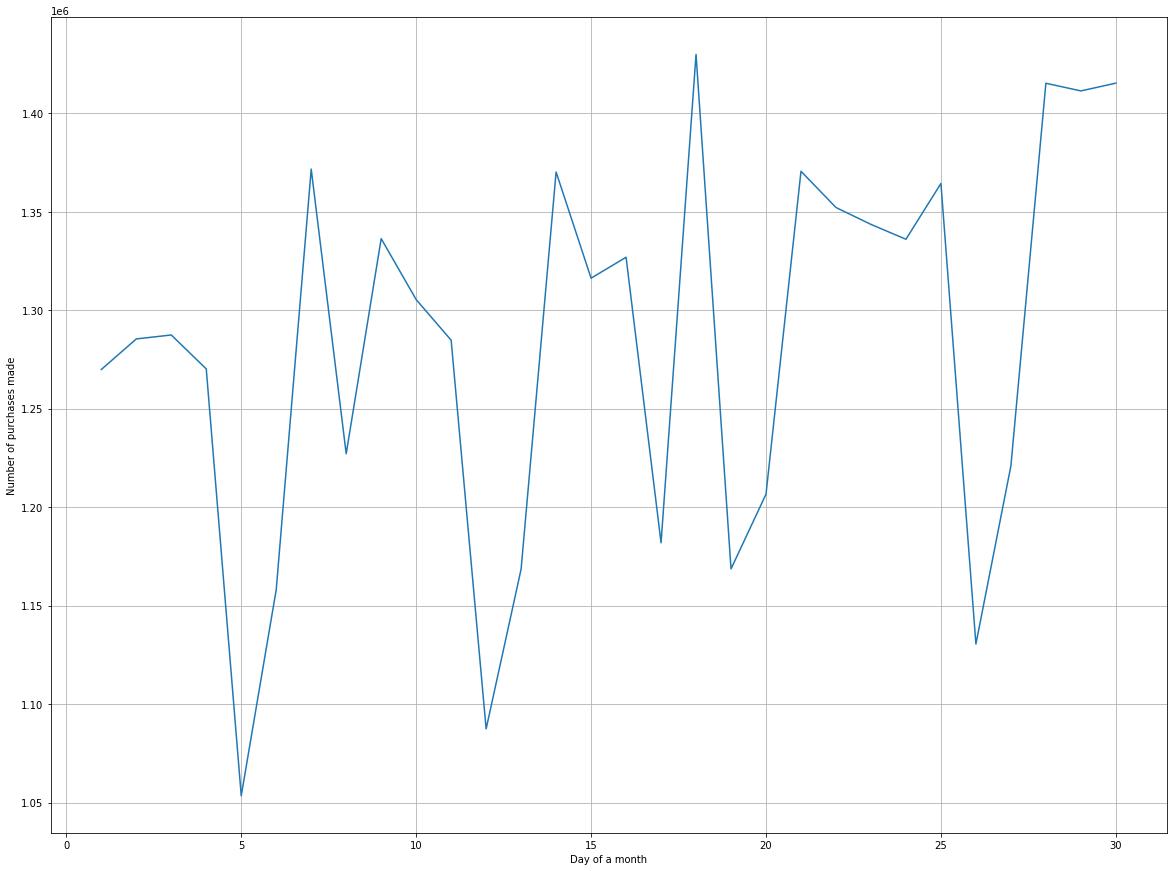

In [44]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,15)
plt.xlabel('Day of a month')
plt.ylabel('Number of purchases made')
plt.grid()
plt.plot(number_of_purchases_per_day)

As it can be seen from a plot, given one month of data, we can't see that there is some increase in orders' number during 1-6 or 20-26 days of a month

## Task 3

Define such cohort existence:
* Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
* Average purchase sum - The customers that usually spend the same amount of money 
* Usual cart - The customers grouped by the product groups

#### Frequent buyers - The users that are shopping frequently(daily, weekly, monthly)  

In [64]:
df['day'] = df['date'].dt.day
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
df['week'] = (df['day'] - df['day_of_week']) / 7

In [65]:
customers_data = df.groupby(['id_card'])

##### Daily

In [66]:
number_of_day_with_purchases = customers_data['day'].nunique()

In [67]:
number_of_day_with_purchases

id_card
0          10
1           1
2           1
3           8
4           5
           ..
1933013     1
1933385     1
1934103     6
1939417     9
1944074     3
Name: day, Length: 1333958, dtype: int64

In [68]:
daily_customers = number_of_day_with_purchases[number_of_day_with_purchases == 30] # since we use September

In [69]:
len(daily_customers)

48

##### Weekly

In [70]:
number_of_weeks_with_purchases = customers_data['week'].nunique()

In [71]:
weekly_customers = number_of_weeks_with_purchases[number_of_weeks_with_purchases == df['week'].nunique()]

In [72]:
len(weekly_customers)

211475

We've found 211475 such customers 

####  Average purchase sum - The customers that usually spend the same amount of money 

In [108]:
customers_docs_data = df.groupby(['id_card', 'id_doc'])
number_of_purchases = customers_docs_data['sum'].count()
sums_of_purchases = customers_docs_data['sum'].sum()

In [109]:
sums_of_purchases_with_more_than_1 = sums_of_purchases[number_of_purchases > 1]
sums_of_purchases_with_more_than_1

id_card  id_doc  
0        60540        251.00
         4304074      260.00
         10805306     329.00
         11746120     209.00
         13712620     924.20
                      ...   
1939417  17169622     396.00
1944074  2746927      791.00
         10459529    2849.13
         15011738     245.00
         18208481     146.00
Name: sum, Length: 5888213, dtype: float64

In [110]:
stds_1 = sums_of_purchases_with_more_than_1.to_frame().reset_index().drop(['id_doc'], axis=1).groupby('id_card').std()

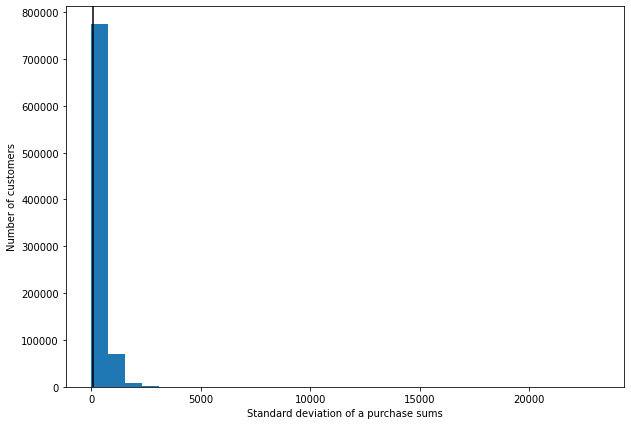

In [111]:
plt.rcParams["figure.figsize"] = (10, 7)
plt.axvline(x=70, color='k')
plt.xlabel('Standard deviation of a purchase sums')
plt.ylabel('Number of customers')
plt.hist(stds_1.dropna(), bins=30);

Consider only frequent customers

In [112]:
sums_of_purchases_20 = sums_of_purchases[number_of_purchases > 20]
stds_20 = sums_of_purchases_20.to_frame().reset_index().drop(['id_doc'], axis=1).groupby('id_card').std()

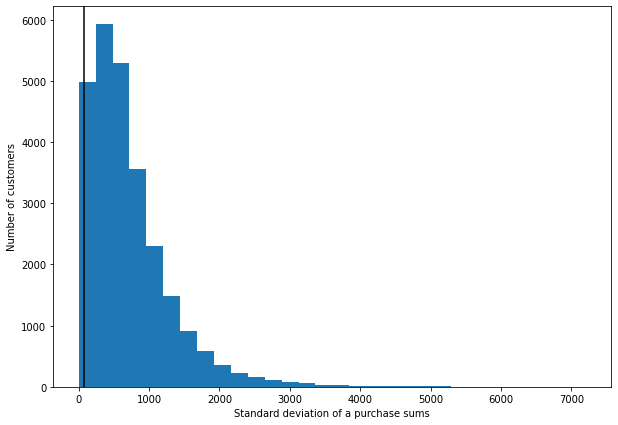

In [113]:
plt.rcParams["figure.figsize"] = (10, 7)
plt.axvline(x=70, color='k')
plt.xlabel('Standard deviation of a purchase sums')
plt.ylabel('Number of customers')
plt.hist(stds_20.dropna(), bins=30);

#### Usual cart - The customers grouped by the product groups  

Text(0, 0.5, 'Count')

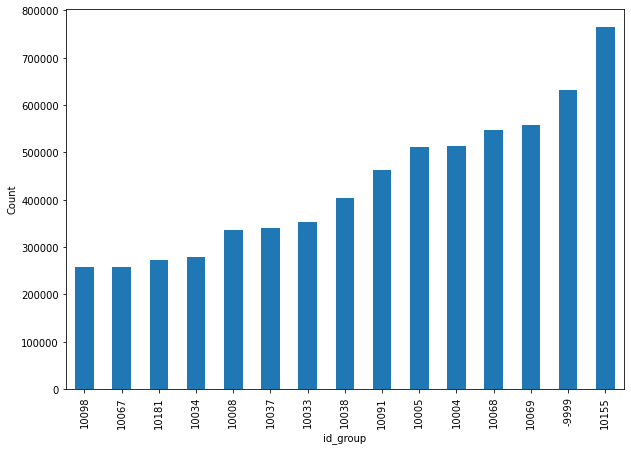

In [121]:
group2num_customers = df.groupby('id_group')['id_card'].unique().apply(len)
group2num_customers.sort_values()[-15:].plot(kind='bar')
plt.rcParams["figure.figsize"] = (5, 3)
plt.ylabel('Count')